In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
 
#import lightgbm as lgb
import catboost as catb

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('features.df')

In [3]:
df['Credit Default'].value_counts()

0    5105
1    2034
Name: Credit Default, dtype: int64

In [4]:
df.columns

Index(['Maximum Open Credit', 'Current Loan Amount', 'Number of Open Accounts',
       'Monthly Debt', 'Annual Income', 'Credit Score', 'Years in current job',
       'Home Ownership', 'Term', 'Years of Credit History', 'Purpose_0',
       'Purpose_1', 'Purpose_2', 'tax_problems_0', 'tax_problems_1',
       'tax_problems_2', 'Current Loan Max', 'Credit Score Max',
       'Credit Default'],
      dtype='object')

In [5]:
#df = df.drop('tax_problems', axis=1)
df.describe()

,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_0,Purpose_1,Purpose_2,tax_problems_0,tax_problems_1,tax_problems_2,Current Loan Max,Credit Score Max,Credit Default
count,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7.139000e+03,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000
mean,76.169670,420.200365,3.099173,155.317899,12.701748,1.889910e+52,0.950693,0.476537,0.258299,0.679367,0.977168,0.018910,0.003922,0.006724,0.979829,0.013447,0.114722,0.053789,0.284914
std,12.898221,101.280797,0.626737,43.572186,0.390135,8.257215e+51,0.216523,0.499484,0.437730,0.466753,0.149379,0.136218,0.062508,0.081727,0.140594,0.115188,0.318708,0.225617,0.451405
min,24.203851,145.059887,1.226202,9.576656,11.063509,3.275465e+50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.325454,350.811560,2.747838,126.784729,12.454089,1.285917e+52,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,76.039566,435.759116,3.063028,155.310890,12.696063,1.993705e+52,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,84.983117,483.864003,3.458633,184.245408,12.950478,2.513306e+52,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,110.311751,647.858465,4.966237,287.023393,14.454391,3.482921e+52,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print(f'TRAIN\n\n{classification_report(y_train_true, y_train_pred)}')
    print(f'TEST\n\n{classification_report(y_test_true, y_test_pred)}')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    for i in range(disbalance_coeff):
        sample = df.loc[df[target_name]==minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
    return df.sample(frac=1)

In [8]:
TARGET_NAME = 'Credit Default'
NUM_FEATURES = ['Maximum Open Credit', 'Current Loan Amount', 'Annual Income', 'Number of Open Accounts',
                'Monthly Debt', 'Credit Score']
FEATURE_NAMES = df.columns.drop(TARGET_NAME)
FEATURE_NAMES = ['Maximum Open Credit', 'Current Loan Amount', 'Number of Open Accounts',
       'Monthly Debt', 'Annual Income', 'Credit Score', 'Years in current job',
       'Home Ownership', 'Term', 'Years of Credit History',
       'Purpose_1', 'Purpose_2', 'tax_problems_0', 'Current Loan Max', 'Credit Score Max']
CAT_FEATURES = set(FEATURE_NAMES).difference(NUM_FEATURES)

In [9]:
X = df[FEATURE_NAMES]
y = df[TARGET_NAME]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=.25, random_state=42)

In [11]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balancing = balance_df_by_target(df_for_balancing, TARGET_NAME)
df_balancing[TARGET_NAME].value_counts()

0    3840
1    3028
Name: Credit Default, dtype: int64

In [12]:
X_train = df_balancing.drop(columns=TARGET_NAME)
y_train = df_balancing[TARGET_NAME]

In [13]:
scaler = StandardScaler()
X_train[NUM_FEATURES] = scaler.fit_transform(X_train[NUM_FEATURES])
X_train.head()

,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_1,Purpose_2,tax_problems_0,Current Loan Max,Credit Score Max
5477,0.494660,0.855817,0.155689,0.598435,-0.637030,0.256900,1,0,0,1,0,0,0,0,0
4395,-0.670107,-1.221003,-0.308308,-0.648746,-1.367313,0.256900,1,0,0,1,0,0,0,0,1
2076,-1.110722,0.183205,0.155689,-1.790958,-1.553402,0.987569,0,0,0,1,0,0,0,1,0
4808,-0.071056,0.592004,-0.067823,0.253570,-0.468774,0.674070,1,0,1,1,0,0,0,0,0
4223,1.270528,0.406880,-1.523190,-1.498611,-0.035654,1.613638,1,1,0,1,0,0,0,0,0


In [14]:
with open('model_scaler', 'wb') as f:
    pickle.dump(scaler, f)

In [15]:
X_test[NUM_FEATURES] = scaler.transform(X_test[NUM_FEATURES])
X_test.head()

<ipython-input-15-71d7a53df9bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[NUM_FEATURES] = scaler.transform(X_test[NUM_FEATURES])
/Users/kosmosivanov/git-repo/Python_DS_more/virt_env/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_1,Purpose_2,tax_problems_0,Current Loan Max,Credit Score Max
3187,-0.589278,-1.115650,-1.169337,-0.484078,-0.062128,0.193066,0,0,0,0,0,0,0,0,0
5541,-0.502879,-0.684357,-0.067823,-1.177943,-0.987655,-0.725191,1,0,1,1,0,0,0,0,0
6092,-1.077555,0.335575,-1.169337,-0.670807,0.125351,-1.119086,1,1,1,1,0,0,0,0,0
744,1.478731,1.706202,0.746669,1.026965,1.154857,-1.021759,1,1,1,0,0,0,0,0,0
1503,1.984107,1.314296,0.746669,0.391678,-0.163368,0.389300,1,0,1,1,0,0,0,0,0


In [16]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.83      0.75      3840
           1       0.70      0.51      0.59      3028

    accuracy                           0.69      6868
   macro avg       0.69      0.67      0.67      6868
weighted avg       0.69      0.69      0.68      6868

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1265
           1       0.57      0.57      0.57       520

    accuracy                           0.75      1785
   macro avg       0.69      0.69      0.69      1785
weighted avg       0.75      0.75      0.75      1785

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1041  224
1                226  294


In [17]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      3840
           1       0.79      0.73      0.76      3028

    accuracy                           0.79      6868
   macro avg       0.79      0.79      0.79      6868
weighted avg       0.79      0.79      0.79      6868

TEST

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1265
           1       0.48      0.51      0.49       520

    accuracy                           0.69      1785
   macro avg       0.63      0.64      0.64      1785
weighted avg       0.70      0.69      0.70      1785

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               973  292
1               254  266


In [18]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)
model_catb.fit(X_train, y_train)
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3840
           1       0.91      0.81      0.86      3028

    accuracy                           0.88      6868
   macro avg       0.89      0.88      0.88      6868
weighted avg       0.89      0.88      0.88      6868

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1265
           1       0.57      0.51      0.54       520

    accuracy                           0.74      1785
   macro avg       0.69      0.67      0.68      1785
weighted avg       0.74      0.74      0.74      1785

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1065  200
1                256  264


In [19]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)

In [20]:
from catboost import cv
params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 200
params['custom_loss'] = 'F1'
params['random_seed'] = 42
params['learning_rate'] = 0.05

cv_date = cv(
    params=params, 
    pool=catb.Pool(data=df[FEATURE_NAMES], label=df[TARGET_NAME], cat_features=CAT_FEATURES),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False
    ,
    verbose=False
    
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [21]:
final_model = catb.CatBoostClassifier(iterations=250, custom_loss=['AUC','Accuracy', 'F1'], 
                                      l2_leaf_reg=3, leaf_estimation_method='Newton',
                                      learning_rate=0.05, silent=True, random_state=42)

In [22]:
final_model.fit(X_train, y_train, cat_features=CAT_FEATURES,
                eval_set=(X_test, y_test),
                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [23]:
final_model.best_iteration_

191

In [24]:
final_model.fit(X_train, y_train, eval_set=(X_test, y_test))
print(final_model.get_params())
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

{'iterations': 250, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'leaf_estimation_method': 'Newton', 'silent': True, 'custom_loss': ['AUC', 'Accuracy', 'F1'], 'random_state': 42}
TRAIN

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      3840
           1       0.82      0.67      0.74      3028

    accuracy                           0.79      6868
   macro avg       0.80      0.78      0.78      6868
weighted avg       0.79      0.79      0.79      6868

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1265
           1       0.56      0.55      0.55       520

    accuracy                           0.74      1785
   macro avg       0.69      0.69      0.69      1785
weighted avg       0.74      0.74      0.74      1785

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1039  226
1                234  286


In [25]:
with open('model_class.bin', 'wb') as f:
    pickle.dump(final_model, f)

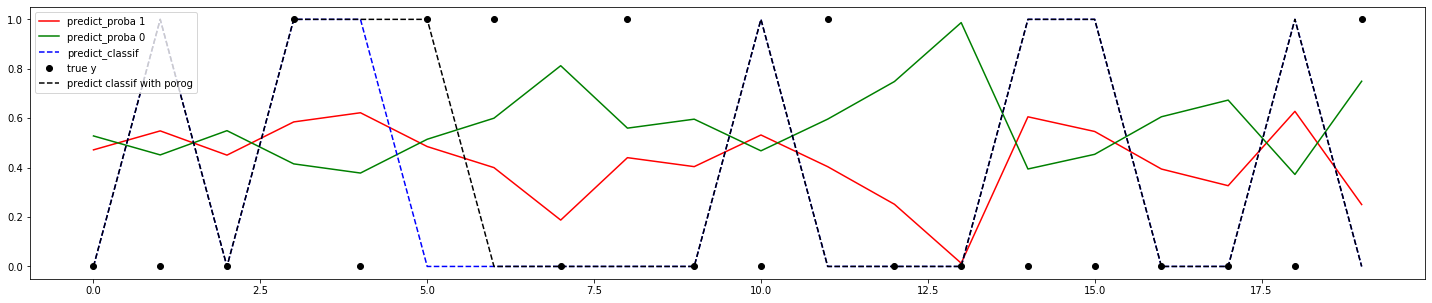

In [26]:
plt.figure(figsize=(25, 5))
plt.plot(y_test_pred_probs[:20, 1], 'r', label='predict_proba 1')
plt.plot(y_test_pred_probs[:20, 0], 'g', label='predict_proba 0')
plt.plot(y_test_pred[:20], '--b', label='predict_classif')
plt.plot(y_test.iloc[:20].values, 'ok', label='true y')

y_p = np.array(y_test_pred_probs[:,1]>0.481).astype('int')
plt.plot(y_p[:20], '--k', label='predict classif with porog')
plt.legend()
plt.show()

In [27]:
y_test_pred_probs

array([[0.52819029, 0.47180971],
       [0.45139492, 0.54860508],
       [0.54951506, 0.45048494],
       ...,
       [0.43089118, 0.56910882],
       [0.64645658, 0.35354342],
       [0.5264737 , 0.4735263 ]])

In [28]:
pd.concat((X_test[:20], y_test[:20]), axis=1)

,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_1,Purpose_2,tax_problems_0,Current Loan Max,Credit Score Max,Credit Default
3187,-0.589278,-1.115650,-1.169337,-0.484078,-0.062128,0.193066,0,0,0,0,0,0,0,0,0,0
5541,-0.502879,-0.684357,-0.067823,-1.177943,-0.987655,-0.725191,1,0,1,1,0,0,0,0,0,0
6092,-1.077555,0.335575,-1.169337,-0.670807,0.125351,-1.119086,1,1,1,1,0,0,0,0,0,0
744,1.478731,1.706202,0.746669,1.026965,1.154857,-1.021759,1,1,1,0,0,0,0,0,0,1
1503,1.984107,1.314296,0.746669,0.391678,-0.163368,0.389300,1,0,1,1,0,0,0,0,0,0
1358,1.371157,1.282849,-0.067823,1.438763,-0.095129,0.674070,1,0,0,0,0,0,0,0,0,1
3200,-0.547584,-1.051500,0.561172,-1.150642,-1.988579,-0.765218,1,0,0,1,0,0,0,0,0,1
813,-0.137233,-0.203155,-0.854031,-0.338815,-0.209400,1.711875,1,1,0,0,0,0,0,0,0,0
1650,0.225089,-0.182787,1.688253,0.358792,-0.736316,0.193066,1,0,0,0,0,0,0,0,0,1
1461,0.954213,-0.198695,0.746669,-0.195899,-0.254992,0.582792,1,0,0,1,0,0,0,0,0,0


In [29]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

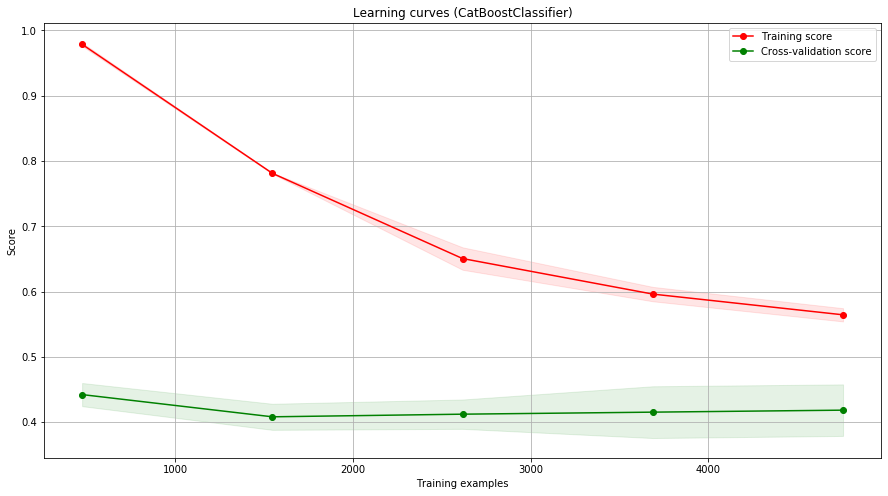

In [30]:
show_learning_curve_plot(final_model, X, y)

In [31]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.475, 0.525, 10):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

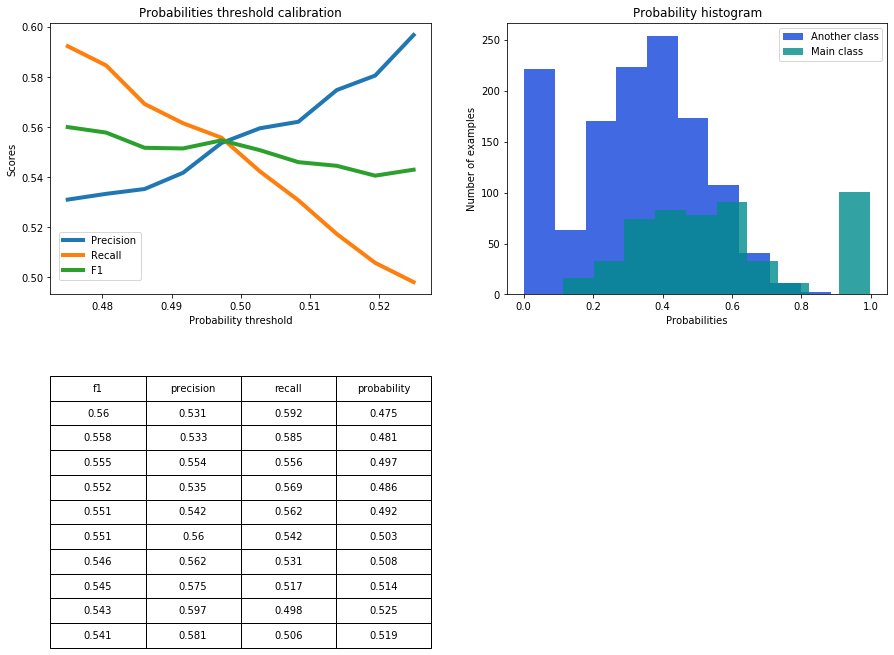

In [32]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [33]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

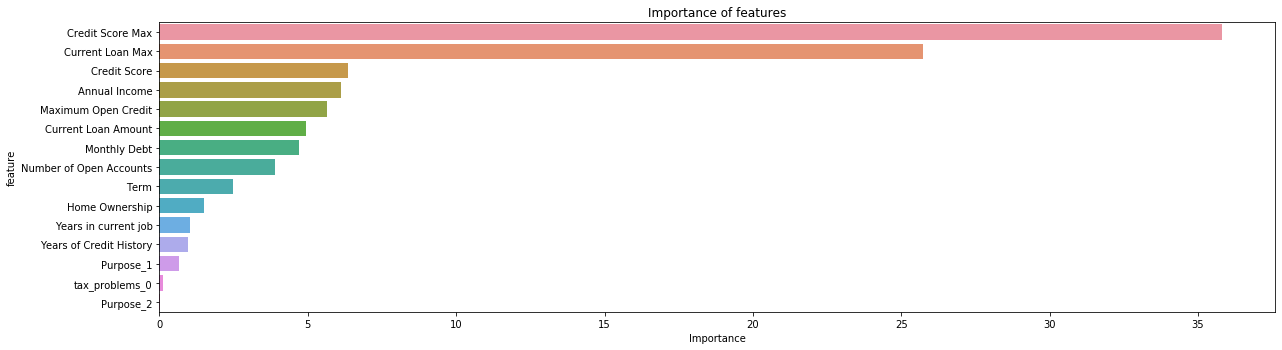

In [34]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)